# Project:

## Implemented LWR vs LWoR.
## Active Learning UNC-PC vs UNC.

In [16]:
import pandas as pd
import nltk as nk
import numpy as np
from sklearn.feature_extraction import stop_words
from collections import Counter
from nltk.stem import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
%matplotlib inline
import random

## Important Note: Change the path of the below files as per your folder.

In [17]:
data1 = pd.read_csv("/Users/Purvank/Desktop/MACHINE LEARNING IIT/CS595_ML/Project/Additional_Files/ride_data1.csv")
data2 = pd.read_csv("/Users/Purvank/Desktop/MACHINE LEARNING IIT/CS595_ML/Project/Additional_Files/ride_data2.csv")

In [18]:
data = pd.concat([data1,data2])

In [19]:
data.head()

,ride_review,ride_rating,sentiment
0,I had just completed running the New York Mara...,1.0,0
1,My appointment time for auto repairs required ...,1.0,0
2,Whether I am using Uber for a ride service or ...,1.0,0
3,Why is it so hard for you to understand that i...,1.0,0
4,"I was in South Beach, FL. I was staying at a m...",1.0,0


In [20]:
c = Counter()
c.update(data['sentiment'])
print (c)

Counter({0: 1111, 1: 233})


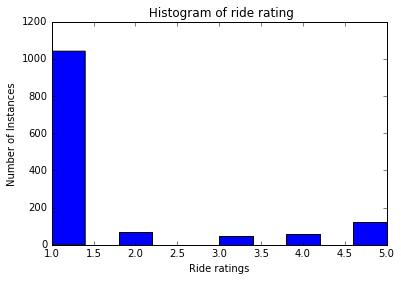

Mean: 1.627
Variance: 1.679


In [21]:
plt.hist(data['ride_rating'])
plt.title(' Histogram of ride rating')
plt.xlabel('Ride ratings')
plt.ylabel('Number of Instances')
plt.show()
print ("Mean: %0.3f"%np.mean(data['ride_rating']))
print ("Variance: %0.3f"%np.var(data['ride_rating']))

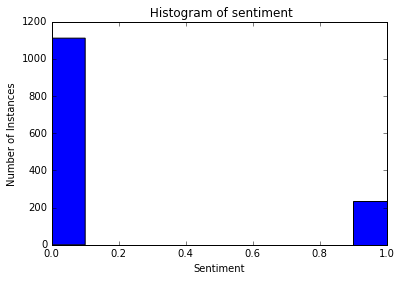

In [22]:
plt.hist(data['sentiment'])
plt.title(' Histogram of sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Instances')
plt.show()

## Provide Rationales

In [23]:
def provide_rationales(data):
    rationales = {}
    for i,r in data.iterrows():
            print (i)
            print (r['ride_review'])
            print ("\n")
            print (r['sentiment'])
            print ("\n")
            rationales[i] = input("rationales")
            print ("\n\n")
    return rationales

## If you want to provide your own rationales, please type "y", and if you want to use existing rationales type "n".

## Important Note: Change the Path of the below file as per your folder.

In [24]:
result = input("Do you want to provide your own rationales?(y/n)")
if(result=='y'):
    rationales = provide_rationales(data)
else:
    data1 = data.copy(deep=True)
    rationales = pd.read_csv("/Users/Purvank/Desktop/MACHINE LEARNING IIT/CS595_ML/Project/Additional_Files/new_rationales.csv")
    rationales['sentiment'] = data['sentiment'].values[0:len(rationales)]

Do you want to provide your own rationales?(y/n)n


## Important Note: Change the parth of the below file as per your folder.

In [25]:
stopwords = stopwords.words('english')
with open("/Users/Purvank/Desktop/MACHINE LEARNING IIT/CS595_ML/Project/Additional_Files/stopwords_stanford") as f:
    stanford_sw = f.readlines()
stanford_sw = [x.strip() for x in stanford_sw]
sw = list(set(stopwords + stanford_sw + list(stop_words.ENGLISH_STOP_WORDS)))

In [26]:
def data_preprocessing(text):
    sb = SnowballStemmer("english")
    for i in range(0,len(text['Rationales'])):
        #print (type(text['Rationales'].iloc[i]))
        try:
            if(not pd.isnull(text['Rationales']).iloc[i]):
                #print (text['Rationales'].iloc[i])
                tokens = word_tokenize(text['Rationales'].iloc[i])
                tokens = [x.lower() for x in tokens if x.lower() not in sw]
                tokens = list(filter(lambda x:x.isalpha(),tokens))
                stem_tokens = [sb.stem(x) for x in tokens]
                c = Counter()
                c.update(stem_tokens)
                d = dict(c)
                seen = set()
                result = []
                for item in tokens:
                    if sb.stem(item) not in seen:
                        seen.add(sb.stem(item))
                        result.append(item)
                review = ' '.join(x for x in result)
                text['Rationales'].iloc[i] = review
            else:
                text['Rationales'].iloc[i] = " "
                #print (type(text['Rationales'].iloc[i]))
                #print (np.isnan(text['Rationales'].iloc[i]))
        except:
            print (text['Rationales'].iloc[i])
    return text

In [27]:
text = data_preprocessing(rationales)

/Users/purvank/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [28]:
def ngrams(text, n):
    return (text[i : i+n] for i in range(len(text)-n+1))

In [29]:
n_gs = []
for i in text['Rationales']:
    n_gs +=  [[x for ngram in ngrams(word_tokenize(i),1) for x in ngram]+[' '.join(ngram) for ngram in ngrams(word_tokenize(i),2)]+[' '.join(ngram) for ngram in ngrams(word_tokenize(i),3)]]

In [30]:
data_ngs = []
for i in data['ride_review']:
    data_ngs +=  [[x for ngram in ngrams(word_tokenize(i),1) for x in ngram]+[' '.join(ngram) for ngram in ngrams(word_tokenize(i),2)]+[' '.join(ngram) for ngram in ngrams(word_tokenize(i),3)]]

## If you want to use binarized data set just change the below file name to "count_vectorizer.csv"

## Important Note: Change the path of the file as per your folder.

In [31]:
tf_idf = pd.read_csv("/Users/Purvank/Desktop/MACHINE LEARNING IIT/CS595_ML/Project/Additional_Files/tf_idf.csv")
tf_idf_1 = tf_idf.copy(deep=True)

In [32]:
positive_class_rationales = []
negative_class_rationales = []
for i in range(0,len(n_gs)):
    rationales = list(set(n_gs[i]).intersection(tf_idf.columns))
    non_rationales = list(set(data.columns) ^ (set(n_gs[i]).intersection(tf_idf.columns)))
    if(data['sentiment'].iloc[i]==1):
        positive_class_rationales += [x for x in rationales]
    else:
        negative_class_rationales += [x for x in rationales]

In [33]:
positive_class_rationales = list(set(positive_class_rationales))
negative_class_rationales = list(set(negative_class_rationales))

In [34]:
def rationales(d,n):
    data = d.head(n=n)
    t = []
    for i,r in data.iterrows():
        rationales = list(set(n_gs[i]).intersection(data.columns))
        non_rationales = list(set(data.columns) ^ (set(n_gs[i]).intersection(data.columns)))
        t.append([1 if x in rationales else 0.01 for x in data.columns.difference(['sentiment'])]+[data['sentiment'].iloc[i]])
    r_values = pd.DataFrame(t,columns=data.columns)
    m = data[data.columns.difference(['sentiment'])].multiply(r_values[r_values.columns.difference(['sentiment'])],axis='columns')
    m['sentiment'] = data['sentiment']
    return m

In [35]:
def active_learning_rationales(index):
    #print (df1.head())
    #print (df1.columns)
    #print (type(df1))
    rats = {}
    df1 = tf_idf_1.loc[index]
    for i in index:
        print (data['ride_review'].iloc[i])
        print ("\n")
        print (data['sentiment'].iloc[i])
        print ("\n")
        change = input("Do you want to change the label for this instance?: ")
        if(change=='y'):
            new_label = input("Provide a new label: ")
            df1['sentiment'].loc[i] = int(new_label)
        print ("\n")
        rats[i] = input("rationales: ")
        print ("\n\n")
    df = pd.DataFrame.from_dict(rats,orient='index')
    #df.head()
    df.columns = ["Rationales"]
    rational_text = data_preprocessing(df)
    n_gs_1 = {}
    j = 0
    for i in rational_text['Rationales']:
        n_gs_1[index[j]] =  [x for ngram in ngrams(word_tokenize(i),1) for x in ngram]+[' '.join(ngram) for ngram in ngrams(word_tokenize(i),2)]+[' '.join(ngram) for ngram in ngrams(word_tokenize(i),3)]
        j+=1
    t1 = []
    for i,r in df1.iterrows():
        rationales1 = list(set(n_gs_1[i]).intersection(df1.columns))
        non_rationales1 = list(set(df1.columns) ^ (set(rationales1)))
        t1.append([1 if x in rationales1 else 0.01 for x in df1.columns.difference(['sentiment'])]+[df1['sentiment'].loc[i]])
    r_values1 = pd.DataFrame(t1,columns=df1.columns,index=df1.index)
    m1 = df1[df1.columns.difference(['sentiment'])].multiply(r_values1[r_values1.columns.difference(['sentiment'])],axis='columns')
    m1['sentiment'] = df1['sentiment']
    return m1,rats

In [36]:
def active_learning_UNC(d,t,index):
    print ("-----------------"+"Active Learning using UNC method"+"---------------------------\n")
    new_data1,rats = active_learning_rationales(index[:5])
    return new_data1,rats

In [37]:
def active_learning_UNC_PC(d,t,index):
    print ("-------------------"+"Active learning using UNC-PC method"+"-----------------------\n")
    positive_negative = []
    u_i = []
    for i in index:
        #positive_negative.append([tuple(set(data_ngs[i]).intersection(positive_class_rationales)),tuple(set(data_ngs[i]).intersection(negative_class_rationales))])
        no_postivie = len(set(data_ngs[i]).intersection(positive_class_rationales))
        no_negative = len(set(data_ngs[i]).intersection(negative_class_rationales))
        if(no_postivie>1 and no_negative>1):
            u_i.append(np.abs(no_postivie-no_negative))
    uncertain_instances = list(np.argsort(u_i)[:5][::1])
    new_data,rats1 = active_learning_rationales(uncertain_instances)
    return new_data,rats1

In [38]:
def model_fitting(train,test,r=False):
    lr = LogisticRegression(class_weight='balanced',random_state=367)
    lr1 = LogisticRegression(class_weight='balanced',random_state=367,penalty='l1')
    lr.fit(train[train.columns.difference(['sentiment'])],train['sentiment'])
    lr1.fit(train[train.columns.difference(['sentiment'])],train['sentiment'])
    pred = lr.predict_proba(test[test.columns.difference(['sentiment'])])
    pred_ = lr1.predict_proba(test[test.columns.difference(['sentiment'])])
    auc1 = 0
    auc2 = 0 
    if(r==True):
        print ("----------------"+"Active Learning"+"-----------------------\n")
        test1 = test.copy(deep=True)
        test2 = test.copy(deep=True)
        UNC_uncertain = list(np.argsort([abs(x[1]-0.5) for x in enumerate(pred[:,0])])[:5])
        UNC_PC_uncertain = list(np.argsort([abs(x[1]-0.5) for x in enumerate(pred[:,0])])[:20])
        we = test.iloc[UNC_PC_uncertain]
        we1 = test.iloc[UNC_uncertain]
        t,rats = active_learning_UNC(data.iloc[list(we1.index)],test.loc[list(we1.index)],we1.index)
        t1,rats1 = active_learning_UNC_PC(data.iloc[list(we.index)],test.loc[list(we.index)],we.index)
        for i,r in t1.iterrows():
            test1.loc[i] = t1.loc[i] 
        for i,r in t.iterrows():
            test2.loc[i] = t.loc[i]
        #print (list(we1.index))
        pred1 = lr.predict_proba(test1[test1.columns.difference(['sentiment'])])
        pred2 = lr.predict_proba(test2[test2.columns.difference(['sentiment'])])
        pred3 = lr1.predict_proba(test1[test1.columns.difference(['sentiment'])])
        pred4 = lr1.predict_proba(test2[test2.columns.difference(['sentiment'])])
        auc = roc_auc_score(test['sentiment'],pred[:,1])
        auc1 = roc_auc_score(test1['sentiment'],pred1[:,1])
        auc2 = roc_auc_score(test2['sentiment'],pred2[:,1])
        auc3 = roc_auc_score(test['sentiment'],pred_[:,1])
        auc4 = roc_auc_score(test1['sentiment'],pred3[:,1])
        auc5 = roc_auc_score(test2['sentiment'],pred4[:,1])
        return auc,auc1,auc2,auc3,auc4,auc5,rats,rats1
    auc = roc_auc_score(test['sentiment'],pred[:,1])
    auc_ = roc_auc_score(test['sentiment'],pred_[:,1])
    return auc,auc_

In [39]:
def results(r=False):
    l = [50,100,150,200,250,300]
    lwr = []
    lwo_r = []
    lwr_l1 = []
    lwo_r_l1 = []
    lwr_UNC_PC = []
    lwr_UNC_PC_l1 = []
    lwr_UNC = []
    lwr_UNC_l1 = []
    rats_UNC_PC = []
    rats_UNC = []
    for i in range(0,len(l)):
        train_rational_data = rationales(tf_idf,l[i])
        train_normal_data = tf_idf.head(n=l[i])
        test_rational_data = tf_idf[l[i]:len(tf_idf)]
        test_normal_data = tf_idf[l[i]:len(tf_idf)]
        print ("----------"+"%d instances"%l[i]+"----------------\n")
        if(r==True):
            auc,auc1,auc2,auc3,auc4,auc5,rats,rats_pc = model_fitting(train_rational_data,test_rational_data,r)
            auc6,auc7 = model_fitting(train_normal_data,test_normal_data)
            print ("-------------Logistic Regression with l2 penalty----------------------")
            print ("AUC of Learning with rationales for %d instances: %f"%(l[i],auc))
            print ("AUC of. Learning without rationals for %d instances: %f"%(l[i],auc6))
            print ("AUC of Active Learning with UNC_PC for %d instances: %f"%(l[i],auc1))
            print ("AUC of Active Learning with UNC for %d instances: %f"%(l[i],auc2))
            print ("-------------Logistic Regression with l1 penalty-----------------------")
            print ("AUC of Learning with rationales for %d instances: %f"%(l[i],auc3))
            print ("AUC of. Learning without rationals for %d instances: %f"%(l[i],auc7))
            print ("AUC of Active Learning with UNC_PC for %d instances: %f"%(l[i],auc4))
            print ("AUC of Active Learning with UNC for %d instances: %f"%(l[i],auc5))
            lwr.append(auc)
            lwo_r.append(auc6)
            lwr_l1.append(auc3)
            lwo_r_l1.append(auc7)
            lwr_UNC_PC.append(auc1)
            lwr_UNC_PC_l1.append(auc4)
            lwr_UNC.append(auc2)
            lwr_UNC_l1.append(auc5)
            for k,v in rats.items():
                temp = [k,v]
                rats_UNC.append(temp)
            for k,v in rats_pc.items():
                temp = [k,v]
                rats_UNC_PC.append(temp)
        else:
            auc1,auc2 = model_fitting(train_rational_data,test_rational_data,r)
            auc3,auc4 = model_fitting(train_normal_data,test_normal_data)
            print ("---------------Logistic Regression with l2 penalty---------------------")
            print ("AUC of Learning with rationales for %d instances: %f"%(l[i],auc1))
            print ("AUC of. Learning without rationals for %d instances: %f"%(l[i],auc3))
            print ("---------------Logistic Regression with l1 penalty----------------------")
            print ("AUC of Learning with rationales for %d instances: %f"%(l[i],auc2))
            print ("AUC of. Learning without rationals for %d instances: %f"%(l[i],auc4))
            lwr.append(auc1)
            lwo_r.append(auc3)
            lwr_l1.append(auc2)
            lwo_r_l1.append(auc4)
        #lwr.append(auc1)
        #lwo_r.append(auc2)
    if(r==True):
        return lwr,lwo_r,lwr_l1,lwo_r_l1,lwr_UNC_PC,lwr_UNC_PC_l1,lwr_UNC,lwr_UNC_l1
    else:
        return lwr,lwo_r,lwr_l1,lwo_r_l1

In [40]:
lwr, lwo_r, lwr_l1, lwo_r_l1 = results(False)

----------50 instances----------------

---------------Logistic Regression with l2 penalty---------------------
AUC of Learning with rationales for 50 instances: 0.806985
AUC of. Learning without rationals for 50 instances: 0.775621
---------------Logistic Regression with l1 penalty----------------------
AUC of Learning with rationales for 50 instances: 0.500000
AUC of. Learning without rationals for 50 instances: 0.500000
----------100 instances----------------

---------------Logistic Regression with l2 penalty---------------------
AUC of Learning with rationales for 100 instances: 0.818724
AUC of. Learning without rationals for 100 instances: 0.825559
---------------Logistic Regression with l1 penalty----------------------
AUC of Learning with rationales for 100 instances: 0.528938
AUC of. Learning without rationals for 100 instances: 0.519032
----------150 instances----------------

---------------Logistic Regression with l2 penalty---------------------
AUC of Learning with rationa

# Important Note: Only run the below cell, when you are using the "tf_idf.csv" file.
## For tf-idf features, learning curve of learning with rationales vs learning without rationales

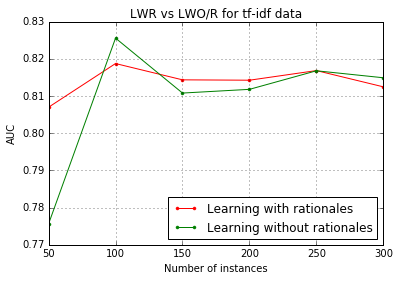

In [192]:
l = [50,100,150,200,250,300]
plt.figure()
plt.title("LWR vs LWO/R for tf-idf data")
plt.xlabel("Number of instances")
plt.ylabel("AUC")
plt.grid()
plt.plot(l,lwr,'.-', color="r",label="Learning with rationales")
plt.plot(l,lwo_r,'.-', color="g",label="Learning without rationales")
plt.legend(loc=4)
plt.show()

# Important Note: Only run the below cell, when you are using "count_vectorizer.csv" file.
## For Binarized data, learning curve of learning with rationales vs learning without rationales

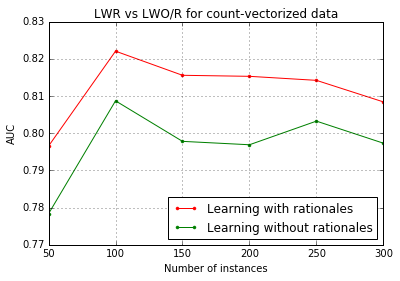

In [77]:
l = [50,100,150,200,250,300]
plt.figure()
plt.title("LWR vs LWO/R for count-vectorized data")
plt.xlabel("Number of instances")
plt.ylabel("AUC")
plt.grid()
plt.plot(l,lwr,'.-', color="r",label="Learning with rationales")
plt.plot(l,lwo_r,'.-', color="g",label="Learning without rationales")
plt.legend(loc=4)
plt.show()

# Important cell: If you run below cells, unless you want to start Active Learning and provide rationales for uncertain instances.


## Only run the below cell, when you are using "count_vectorizer.csv" as a data.
## For bag of words based data, learning curve of UNC-PC vs UNC

In [78]:
lwr,lwo_r,lwr_l1,lwo_r_l1,lwr_UNC_PC,lwr_UNC_PC_l1,lwr_UNC,lwr_UNC_l1 = results(True)

----------50 instances----------------

----------------Active Learning-----------------------

-----------------Active Learning using UNC method---------------------------

Their P.O.S. survey vehicle causes $4600.00 damage to my truck.  They DO NOT have insurance.  So, you, Mr. Driver, get your arse sued.  Welcome to UBER!  Michael Hung Thai Pham the subpoena is on it's way.  You WILL need a lawyer.  Still love Uber?  Ciao.


0


Do you want to change the label for this instance?: n


rationales: damage. sued. subpeona



I purchased an Uber gift card in the amount of $25.00 for my son to use. He tried to redeem it, however Uber asked him for a credit card which he does not have... Hence, me buying the Uber gift card for him. In an attempt to satisfy Uber's request, I purchased another gift card for $25.00 thinking this could act as the secondary. Instead the Uber app requested my son provide credit card info again. So, I finally caved and provided a credit card to my son as a back-u

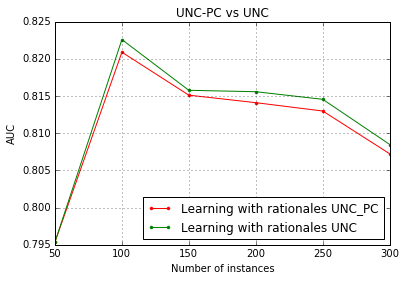

In [79]:
l = [50,100,150,200,250,300]
plt.figure()
plt.title("UNC-PC vs UNC")
plt.xlabel("Number of instances")
plt.ylabel("AUC")
plt.grid()
plt.plot(l,lwr_UNC_PC,'.-', color="r",label="Learning with rationales UNC_PC")
plt.plot(l,lwr_UNC,'.-', color="g",label="Learning with rationales UNC")
plt.legend(loc=4)
plt.show()

## Only run the below cell when you are using "tf_idf.csv" as a data
## For count vectorized based features, learning curve of UNC-PC vs UNC

In [91]:
lwr,lwo_r,lwr_l1,lwo_r_l1,lwr_UNC_PC,lwr_UNC_PC_l1,lwr_UNC,lwr_UNC_l1 = results(True)

----------50 instances----------------

----------------Active Learning-----------------------

-----------------Active Learning using UNC method---------------------------

My  man Charles!! He is the best driver of uber!! He knows where to go and is a very safe driver!! Very sociable and kind!! Thank you Charles for your safe driving and making sure we get home safely!!!


1


Do you want to change the label for this instance?: n


rationales: best. very safe. very sociable and kind. safely.



For myself Uber has been a pleasant surprise. After reading through a hundred plus reviews and watching a few YouTube related videos(hysterical). I found myself uncertain if I wanted to join the Uber Brigade. The reviews seemed for the most part, to be negative. Not enough pay, a lot of down time etc. For myself, Everytime I flip on the Uber app it's non stop, until I stop. However I live in Toronto and I only use it part time. I have a full time gig. If I work Uber its 2 to 4 hrs a night Mond

/Users/purvank/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)




rationales: gripes. No flat rate. stuck. indicate FasTrak transponder. stuck in traffic. unaware of their surroundings. hogs too much memory.comparison, Lyft's.



I would file a class action suit against Uber. I do not use this service and get billed! My card was taken and used. This company is not checking identification to match cards used for service purchases. This company and/or drivers are allowing minors to ride without permission and are using unauthorized debit & credit cards. There is no direct contact number to resolve these issues unless you create an Uber account. Has this happened to anyone else?


0


Do you want to change the label for this instance?: n


rationales: file a class action suit against. card was taken and used. not checking identification. allowing minors to ride. unauthorized debit & credit cards.issues.



I had just completed running the New York Marathon and had requested an Uber Pool ride back to my hotel. First, let me tell you what started out ri

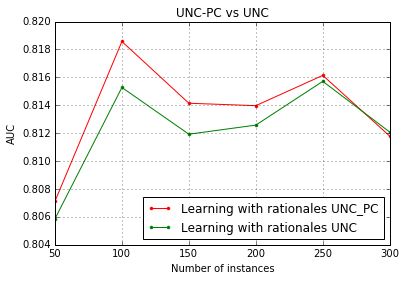

In [92]:
l = [50,100,150,200,250,300]
plt.figure()
plt.title("UNC-PC vs UNC")
plt.xlabel("Number of instances")
plt.ylabel("AUC")
plt.grid()
plt.plot(l,lwr_UNC_PC,'.-', color="r",label="Learning with rationales UNC_PC")
plt.plot(l,lwr_UNC,'.-', color="g",label="Learning with rationales UNC")
plt.legend(loc=4)
plt.show()

In [93]:
## End of Ipython Notebook